In [63]:
import os
import numpy as np

images = os.listdir("imagenes/")


In [65]:
import re

clases = ["0-20","20-40","40-60","60-80","80-100"]
clase = []

for img in images:
    lista = re.sub(".jpg","", img).split(sep='_')

    losses = float(lista[11])
    
    if losses > 0.8:
        clase.append(4)
    elif losses > 0.6:
        clase.append(3)
    elif losses > 0.4: 
        clase.append(2)
    elif losses > 0.2: 
        clase.append(1)
    else:
        clase.append(0)
    #print(losses, clase[-1])

for i, c in enumerate(clases):
    print(f'Clase: {c}. Cantidad de imágenes: {clase.count(i)}')

Clase: 0-20. Cantidad de imágenes: 27537
Clase: 20-40. Cantidad de imágenes: 4846
Clase: 40-60. Cantidad de imágenes: 3772
Clase: 60-80. Cantidad de imágenes: 6570
Clase: 80-100. Cantidad de imágenes: 3029


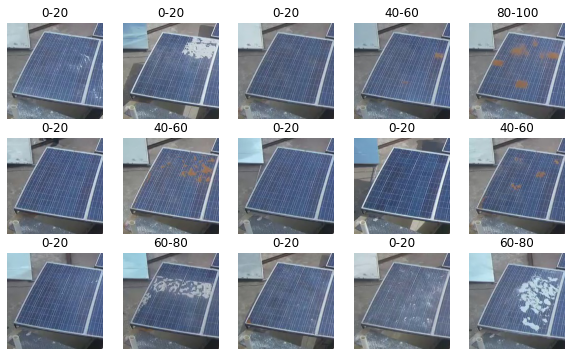

In [68]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(images)-1)
        img = io.imread("imagenes/" + images[ix])
        ax.imshow(img)
        #print(img.shape)
        ax.axis('off')
        ax.set_title(clases[clase[ix]])
plt.show()

In [53]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(images, clase, test_size=0.2, stratify=clase)

len(train_imgs), len(test_imgs)

(36603, 9151)

In [54]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, trans, device):
        self.X = X
        self.y = y
        self.trans = trans
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        # cargar la imágen
        img = io.imread("imagenes/" + self.X[ix])
        # aplicar transformaciones
        if self.trans:
            img = self.trans(image=img)["image"]
        return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [55]:
import albumentations as A

trans = A.Compose([
    A.Resize(192, 192)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(36603, 9151)

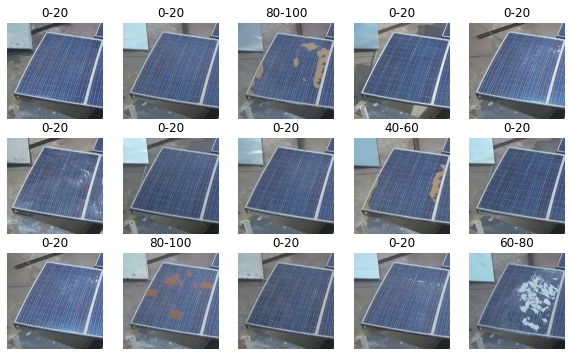

In [56]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(dataset['train'])-1)
        img, lab = dataset['train'][ix]
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
        ax.set_title(clases[lab])
plt.show()

In [57]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 192, 192])

In [58]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
class Model(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()
        # descargamos resnet
        resnet = torchvision.models.resnet18(pretrained=pretrained)
        # nos quedamos con todas las capas menos la última
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
        if freeze:
            for param in self.resnet.parameters():
                param.requires_grad=False
        # añadimos una nueva capa lineal para llevar a cabo la clasificación
        self.fc = torch.nn.Linear(512, 5)

    def forward(self, x):
        x = self.resnet(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad=True

In [60]:
model = Model()
outputs = model(torch.randn(64, 3, 192, 192))
outputs.shape

c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([64, 5])

In [61]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [62]:
model = Model()
fit(model, dataloader, epochs=15)

val_loss 1.90357 val_acc 0.19136: 100%|██████████| 36/36 [00:37<00:00,  1.03s/it]


Epoch 1/15 loss 0.51889 val_loss 1.90357 acc 0.84224 val_acc 0.19136


val_loss 1.07760 val_acc 0.58030: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Epoch 2/15 loss 0.34038 val_loss 1.07760 acc 0.89743 val_acc 0.58030


val_loss 0.56042 val_acc 0.85986: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]


Epoch 3/15 loss 0.31558 val_loss 0.56042 acc 0.89962 val_acc 0.85986


val_loss 0.40137 val_acc 0.87288: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Epoch 4/15 loss 0.29962 val_loss 0.40137 acc 0.90477 val_acc 0.87288


val_loss 0.42981 val_acc 0.88153: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Epoch 5/15 loss 0.28840 val_loss 0.42981 acc 0.90539 val_acc 0.88153


val_loss 0.44812 val_acc 0.86358: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s]


Epoch 6/15 loss 0.27324 val_loss 0.44812 acc 0.90815 val_acc 0.86358


val_loss 0.34524 val_acc 0.89509: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s]


Epoch 7/15 loss 0.26145 val_loss 0.34524 acc 0.91113 val_acc 0.89509


val_loss 0.33672 val_acc 0.89903: 100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


Epoch 8/15 loss 0.24989 val_loss 0.33672 acc 0.91334 val_acc 0.89903


val_loss 0.40502 val_acc 0.87375: 100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


Epoch 9/15 loss 0.23845 val_loss 0.40502 acc 0.91687 val_acc 0.87375


val_loss 0.45193 val_acc 0.86217: 100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


Epoch 10/15 loss 0.22798 val_loss 0.45193 acc 0.91883 val_acc 0.86217


val_loss 0.38444 val_acc 0.88105: 100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


Epoch 11/15 loss 0.21406 val_loss 0.38444 acc 0.92426 val_acc 0.88105


val_loss 0.38419 val_acc 0.88069: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


Epoch 12/15 loss 0.20393 val_loss 0.38419 acc 0.92574 val_acc 0.88069


val_loss 0.31999 val_acc 0.89650: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


Epoch 13/15 loss 0.19163 val_loss 0.31999 acc 0.92834 val_acc 0.89650


val_loss 0.32474 val_acc 0.89187: 100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


Epoch 14/15 loss 0.17913 val_loss 0.32474 acc 0.93307 val_acc 0.89187


val_loss 0.33266 val_acc 0.90186: 100%|██████████| 36/36 [00:20<00:00,  1.76it/s]

Epoch 15/15 loss 0.16976 val_loss 0.33266 acc 0.93689 val_acc 0.90186


torch.Size([1, 3, 192, 192])

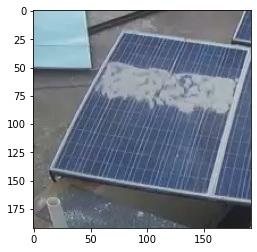

In [152]:
from skimage.transform import rescale, resize, downscale_local_mean
prueba = io.imread("pppp.jpg")
#prueba = resize(prueba, (192,192))
prueba = trans(image=prueba)["image"]

import matplotlib.pyplot as plt

plt.imshow(prueba)

prueba = torch.from_numpy(prueba / 255.).float().permute(2,0,1)

prueba = prueba.reshape(1,3,192,192)

prueba.shape

In [153]:
prueba = prueba.to(device)

In [154]:
model(prueba)

tensor([[-0.2041, -1.0488, -2.4851, -0.7806,  6.0593]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [103]:
bar = tqdm(dataloader['test'])

for i in bar:
    x, y = i
    x = x.to(device)
    print(model(x))

tensor([[ 6.4373,  1.3288, -0.5647, -4.0899, -2.1210],
        [ 1.3365,  5.5479,  1.9403, -2.9964, -4.3173],
        [-0.3568, -2.6355, -2.6729,  1.3016,  5.6232],
        ...,
        [-2.6761, -2.7383,  0.4440,  5.0280,  0.7881],
        [ 7.2048,  0.5026, -0.9330, -4.0807, -1.3858],
        [ 4.8196,  1.7957, -0.7164, -2.0581, -2.7490]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-2.8694, -1.8201,  1.0634,  5.9416, -1.2489],
        [ 2.3962,  6.9636,  0.0319, -4.1458, -3.5836],
        [ 3.8537,  0.8865,  0.1043, -1.3315, -2.1150],
        ...,
        [ 8.0177,  1.7466,  0.0378, -5.0302, -3.2197],
        [-2.7194, -1.3337,  3.0270,  3.9413, -1.8905],
        [ 5.2106,  1.2030, -0.2036, -3.2381, -1.7469]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 5.9697,  1.2529, -1.4061, -2.5153, -2.0699],
        [-1.7406, -0.4809,  6.1099,  0.1063, -2.3645],
        [ 5.5579,  2.2491, -0.6336, -2.9261, -2.4692],
        ...,
        [ 0.4037, -1.5306, -0.7091,  0.2678,  3.3369],
        [ 5.1741,  2.6397, -0.2956, -3.6348, -2.4425],
        [ 7.6867, -0.5290, -2.7072, -3.0053,  0.1820]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-2.4466, -2.5757, -1.7877,  6.5470,  1.2936],
        [ 8.1269,  0.9957, -2.8423, -4.1136, -0.7507],
        [ 3.7083,  1.0024, -1.3686, -2.1445, -0.0104],
        ...,
        [ 8.8945, -0.9737, -2.4976, -3.2202, -0.9409],
        [-0.3583,  0.9092,  2.4840, -0.2280, -0.9596],
        [ 6.8053,  4.1096, -1.0187, -4.7648, -3.9126]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 3.5550,  2.3643,  1.0133, -2.3030, -3.5727],
        [ 7.4968,  2.9956, -1.9252, -4.0213, -3.5021],
        [ 7.0535,  0.2201, -0.5034, -3.1058, -1.9736],
        ...,
        [ 7.0980,  3.3210, -0.3971, -4.9949, -4.2670],
        [ 6.4166,  2.6777, -1.2342, -3.6743, -2.7780],
        [ 3.3069,  2.8147,  0.3004, -2.3289, -2.7519]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-0.0518,  1.3442,  2.7142, -0.6949, -1.3384],
        [ 0.1197,  3.3002,  1.8743, -1.8239, -1.5225],
        [ 8.0037,  1.6915, -1.0350, -4.0406, -3.2125],
        ...,
        [ 4.0033,  2.2871, -0.0927, -1.6916, -3.1523],
        [-1.1553,  0.3408,  4.1007,  0.9241, -2.7839],
        [ 3.0772,  2.9186,  0.1786, -2.5979, -2.1834]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 6.5950,  3.0544, -0.6535, -4.4414, -2.8037],
        [ 3.1112, -1.1517, -2.4511, -1.7976,  3.9025],
        [ 5.4361,  0.1813,  0.3239, -2.1362, -2.7285],
        ...,
        [ 8.5061, -0.2109, -2.1984, -3.1161, -1.9674],
        [ 4.0751,  0.9601, -1.0560, -2.4932,  0.0320],
        [ 1.4454, -2.1296, -3.2935, -1.6298,  7.8557]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 3.5629,  0.5005, -1.2138, -0.9936, -0.4073],
        [ 6.3371,  2.3029,  0.1771, -3.9137, -3.4509],
        [-2.8566,  2.1889,  3.5325,  0.9283, -1.6773],
        ...,
        [ 7.6692,  0.8126, -0.1451, -4.7407, -2.1840],
        [ 6.5962, -0.4782, -1.2378, -2.4369, -1.0802],
        [ 5.1772,  0.6257, -1.2025, -1.0156, -2.1802]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 5.9432, -0.3686, -1.3315, -2.6599, -0.4527],
        [ 7.2273, -0.6378, -2.0473, -3.2918,  0.6944],
        [-1.5333, -5.9770, -3.6440,  4.8739,  7.5130],
        ...,
        [-3.3235, -1.5575,  0.0754,  5.0026,  0.7938],
        [-0.0733, -1.0638, -2.7226, -0.5942,  6.1057],
        [ 8.6696,  1.1174, -1.8617, -3.6069, -3.0475]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 7.0809,  0.5667, -2.8099, -3.1382, -0.2814],
        [-2.3978, -4.1943, -1.7204,  3.3527,  5.6712],
        [ 0.0920,  3.5364,  4.0408, -2.1026, -3.5645],
        ...,
        [ 2.5801,  5.3615,  0.8182, -2.9573, -4.0595],
        [-1.9061,  4.0013,  2.5946, -0.5243, -2.1767],
        [-0.1238, -5.0827, -4.2419,  3.0807,  7.6120]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-1.7748, -2.7577,  1.8832,  5.0288, -1.4749],
        [ 7.5802,  2.4039, -0.5441, -4.0382, -4.4149],
        [-3.1465, -3.6368, -0.7610,  3.1545,  5.5700],
        ...,
        [ 7.3174, -0.8157, -1.4721, -3.3594,  0.0351],
        [ 7.5042, -0.9688, -1.8325, -3.1943, -0.1437],
        [-0.1304,  1.9280,  3.1637, -0.9347, -2.1776]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-2.2526, -3.3455,  4.0861,  4.1913, -1.2801],
        [ 5.8760,  0.9039, -0.6451, -2.7432, -2.1933],
        [ 6.5450,  3.1944, -1.7431, -3.1946, -3.4055],
        ...,
        [ 5.0816,  2.1388, -0.1804, -2.1364, -3.1718],
        [ 6.2955,  1.5000, -0.3187, -3.4637, -2.9278],
        [-2.4450, -1.1279,  0.0203,  4.7597, -0.1160]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 6.7469, -0.0717, -2.2247, -2.3948, -0.7956],
        [-2.4335, -2.0243,  1.1455,  5.9098, -1.8478],
        [ 7.8464,  1.1877, -1.0602, -4.2809, -2.3933],
        ...,
        [ 2.2636,  1.3645,  1.7285, -1.8103, -1.9378],
        [ 6.9699,  2.7945, -1.1458, -3.9542, -3.0750],
        [-1.6180,  0.8797,  4.8660,  0.8650, -3.0135]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-3.0419, -1.8302,  1.7511,  5.8143, -1.4944],
        [ 5.8906,  0.0362, -0.3564, -2.9127, -1.5077],
        [ 3.6566, -0.2049, -0.6813, -1.4634,  0.5675],
        ...,
        [-1.7135,  2.7985,  4.6586, -0.7378, -2.8141],
        [ 6.0985,  1.5494, -1.1844, -2.6618, -2.3596],
        [ 4.0647,  1.9821, -0.5180, -1.7683, -2.4773]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-0.9869, -4.5054, -2.7214,  2.7623,  6.3345],
        [ 7.9696,  0.7803, -1.5384, -3.6478, -2.3898],
        [ 7.6778, -0.9724, -1.2098, -4.0440,  0.2258],
        ...,
        [ 1.1046,  1.9162,  3.9882, -1.8553, -3.1991],
        [ 6.0163,  1.7492, -0.5964, -3.4558, -2.2153],
        [ 7.1856,  1.0153, -1.5151, -3.4712, -1.8760]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 8.2271,  3.1515, -0.5454, -5.5838, -3.7465],
        [ 3.0681,  6.0365,  1.5253, -3.6050, -5.1960],
        [-0.0093,  3.6732,  3.1840, -2.1244, -3.1351],
        ...,
        [ 6.4824,  1.0908, -1.4830, -4.0581, -0.7644],
        [ 6.5861,  0.5533, -0.5769, -2.6297, -2.4535],
        [-3.0207, -2.3618, -1.7467,  6.4327,  1.6770]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 4.2574,  1.5217, -0.4969, -1.2861, -2.8421],
        [ 6.4126,  1.6749, -1.0691, -2.9869, -2.7593],
        [ 4.7197,  1.6153, -0.5008, -3.5365, -0.6847],
        ...,
        [ 8.3327,  0.4459, -1.2355, -3.7910, -2.4101],
        [-0.6730, -2.8865, -1.8101,  0.8035,  5.7202],
        [ 7.6742,  0.2839, -1.7369, -3.8882, -0.9054]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-0.0752,  6.9479,  1.1806, -1.8715, -4.2138],
        [-4.4822, -1.7085, -0.3632,  4.1902,  4.0370],
        [ 5.2249,  2.8330,  0.3136, -3.7610, -3.6207],
        ...,
        [-2.8769, -2.8641,  0.5376,  6.9421, -0.9280],
        [ 8.0265, -0.1839, -2.0433, -3.3501, -1.2446],
        [ 3.7073,  1.0974,  0.4230, -1.6750, -2.2787]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 6.7339,  1.6981, -1.5764, -3.3602, -2.0516],
        [ 2.2325,  4.8715,  1.3185, -2.6290, -4.3240],
        [ 2.0858,  5.1620,  1.5223, -2.8553, -4.5762],
        ...,
        [ 2.0276,  5.3965,  0.7833, -2.7341, -3.6232],
        [ 1.9031,  7.1483,  0.4672, -3.5198, -4.5252],
        [ 5.2428,  2.2179, -0.8400, -3.0477, -1.9784]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 4.8842,  2.6895, -0.6400, -2.4190, -3.5052],
        [ 7.4589,  1.8468, -1.9143, -3.6800, -2.2773],
        [ 8.1514,  1.3601, -0.8969, -3.7626, -3.2451],
        ...,
        [-0.8054,  2.7173,  4.8626, -1.6758, -2.7998],
        [ 1.2927,  4.8513,  1.3410, -1.9488, -3.7420],
        [ 8.0798,  1.6591, -0.7884, -4.3646, -3.0370]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-0.9007, -0.9900, -0.3184,  4.0560, -0.7540],
        [ 8.6980,  1.4576, -2.8852, -3.9684, -1.8199],
        [ 4.9926,  2.4568, -0.0653, -3.5662, -2.5144],
        ...,
        [ 6.2567,  1.6212,  0.3361, -3.6356, -3.3626],
        [-1.6287, -2.1562, -0.9144,  1.9412,  4.0939],
        [ 1.2776, -1.8602, -0.5980,  0.4523,  2.1445]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 8.1995,  0.8229, -2.7895, -3.2586, -1.7080],
        [ 1.8112,  2.8378,  1.0523, -1.0832, -2.8454],
        [ 7.2336,  2.8825, -0.2583, -5.4477, -2.5133],
        ...,
        [ 4.2930,  1.4126,  0.4919, -2.5954, -2.4488],
        [-1.9059, -1.4569, -0.5531,  5.5887, -0.5299],
        [ 7.5672, -0.0837, -2.7722, -2.8497, -0.2816]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 3.0055,  0.3659,  0.5872, -0.5210, -2.2457],
        [-1.6881, -1.9957,  4.4259,  2.3525, -1.6912],
        [ 7.0908,  2.6456, -1.8911, -3.8942, -2.8277],
        ...,
        [ 8.2832, -0.3163, -1.4453, -3.5221, -1.7825],
        [ 0.1403, -2.3774, -2.4116,  0.7153,  5.4379],
        [ 6.5301,  0.7450, -0.1271, -3.4622, -2.2763]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-1.5437, -3.1320, -1.9248, -0.0124,  8.0525],
        [ 9.1169, -1.1866, -3.2796, -2.5740, -0.5951],
        [-0.5887, -2.9022, -1.6375,  1.8452,  4.3485],
        ...,
        [ 7.4631,  1.6410, -1.2822, -3.5467, -3.0383],
        [-0.3933, -0.2745,  4.5740, -0.2961, -1.6657],
        [-2.3703, -1.7518,  0.0872,  5.9890, -0.9915]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 3.8912,  1.0649,  0.5776, -1.6742, -2.4760],
        [ 1.0954,  5.7803,  2.2958, -3.1552, -4.1348],
        [10.6044,  1.2406, -2.9992, -5.2012, -2.3443],
        ...,
        [ 6.9446,  3.3577, -1.2808, -4.5313, -3.3771],
        [ 8.9897, -0.9561, -2.6680, -2.4597, -1.5045],
        [ 7.4131, -0.7590, -2.0625, -3.1370, -0.2277]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 3.6325,  0.4616, -0.2051, -1.3391, -0.9665],
        [ 8.4121,  3.0629, -2.3842, -4.8373, -3.1600],
        [-1.8311, -1.7343,  0.4737,  5.5896, -1.6406],
        ...,
        [ 5.9698,  2.6110, -0.6029, -4.0500, -2.0731],
        [-3.7522, -4.2378,  2.6516,  6.6093, -0.1899],
        [ 6.3314,  2.2708, -0.2007, -3.9667, -3.0488]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 6.5695,  2.1962, -2.1583, -3.4307, -1.8097],
        [ 4.2958,  1.3402,  0.4244, -1.6705, -2.8974],
        [ 0.1550,  4.7176,  4.2278, -2.7646, -4.5743],
        ...,
        [-1.1919, -2.1125, -1.3273,  5.9793, -0.1299],
        [ 5.3570,  1.2279, -0.5870, -2.4459, -2.1196],
        [ 3.2439,  1.6282,  0.0828, -2.5520, -0.9946]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 7.5126,  2.3210, -0.7272, -3.8940, -4.2047],
        [ 7.4603,  0.3992, -2.1163, -4.0858, -0.3039],
        [-4.0154, -3.4057,  0.9675,  8.3655, -1.0248],
        ...,
        [ 6.7098,  2.5577, -2.2585, -3.6884, -1.8729],
        [ 1.9842,  5.5202,  1.2544, -2.9588, -4.2390],
        [ 6.9840, -0.1282, -2.5880, -2.9414,  0.5038]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-2.8428, -4.2622, -3.6801,  2.5906,  9.8221],
        [ 5.9997,  2.3603, -0.5976, -2.4978, -3.9352],
        [-1.0674, -1.7631, -1.4321,  2.0199,  3.9367],
        ...,
        [ 5.9996,  1.2454, -0.5801, -3.2582, -2.1998],
        [ 7.0154,  3.0280, -0.2125, -4.2086, -4.4655],
        [-3.5812, -1.4252,  0.7378,  5.2253,  0.2623]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 4.9850,  2.0264, -1.6452, -3.4747, -0.6817],
        [ 8.5307, -1.3480, -2.3555, -2.6119, -0.9025],
        [ 6.7352, -1.1957, -2.1745, -1.9220, -0.3450],
        ...,
        [ 6.6322,  1.8484, -1.8459, -3.6741, -1.7973],
        [ 6.9967,  2.2149, -0.9773, -3.3441, -3.3261],
        [ 5.2946,  4.9605,  1.0715, -4.8443, -5.0529]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 1.3869, -1.7863, -1.3637,  0.1447,  3.4103],
        [ 9.0593,  1.0579, -2.0810, -4.4745, -2.2587],
        [-3.4460, -2.4271,  2.7937,  5.4852, -1.0399],
        ...,
        [-1.0426,  0.7406,  3.1008,  0.3880, -1.2636],
        [ 8.8295, -0.0702, -1.7816, -4.6956, -0.8764],
        [ 6.1626,  2.0610, -0.9362, -2.8811, -3.1006]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 7.0957,  0.3885, -0.3087, -3.4129, -2.4019],
        [ 6.6430,  2.6507, -0.2936, -4.7623, -3.2996],
        [ 9.0988,  3.0560, -1.5476, -5.2413, -3.8607],
        ...,
        [ 3.8742,  1.7395,  0.6358, -2.1071, -2.6440],
        [-0.0887, -4.5672, -1.6424,  2.1770,  5.4024],
        [ 7.1197,  2.2407, -1.1276, -3.7783, -3.0051]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 5.3293,  0.5147, -0.6491, -2.3951, -1.4904],
        [ 4.2696,  2.4038, -0.5581, -2.3463, -2.5296],
        [ 8.3743, -1.2242, -2.5116, -3.2023, -0.0188],
        ...,
        [ 2.8840,  5.7741,  0.4223, -3.2357, -4.2979],
        [ 5.3220,  1.2529, -0.8985, -4.1021, -0.2254],
        [ 8.7213, -0.0967, -2.1138, -4.1614, -0.7848]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[ 3.7968,  0.6331,  0.5312, -1.5520, -1.3533],
        [ 5.5792,  1.4368,  0.0977, -2.6076, -3.1545],
        [ 4.7624,  0.7939,  0.6741, -2.6043, -2.2877],
        ...,
        [ 4.9121,  1.7981,  0.2201, -3.0298, -2.9146],
        [ 4.9611, -2.4599, -1.0798, -0.9716,  0.7592],
        [ 6.3164,  2.1690, -0.1874, -3.6275, -3.5062]], device='cuda:0',
       grad_fn=<AddmmBackward>)


tensor([[-0.1278,  5.2733,  2.6379, -2.4708, -3.5329],
        [ 5.8974,  1.4460,  0.0384, -2.9698, -3.2364],
        [ 5.8017,  1.8056, -1.1622, -3.1719, -1.9108],
        ...,
        [ 6.0210,  1.6645,  0.0164, -3.0211, -3.4240],
        [ 4.8732,  1.4196,  0.6565, -2.7439, -2.7589],
        [ 5.7174,  0.7711, -1.6136, -2.3070, -1.2752]], device='cuda:0',
       grad_fn=<AddmmBackward>)


100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

tensor([[ 6.5295e+00,  1.6701e+00, -2.7003e-01, -3.1111e+00, -3.5175e+00],
        [ 5.3835e+00,  5.6439e-01, -1.6777e+00, -2.1899e+00, -8.4770e-01],
        [ 4.7076e+00,  1.7018e+00,  5.9685e-01, -3.0550e+00, -2.3869e+00],
        [ 4.5750e+00, -1.0431e+00, -2.0603e+00, -1.4159e+00,  1.6145e+00],
        [ 4.2003e-01,  4.6183e+00,  2.8392e+00, -2.2002e+00, -3.8182e+00],
        [ 7.2950e+00,  2.4360e+00, -7.4285e-01, -4.5053e+00, -3.3161e+00],
        [ 7.2456e+00,  6.3308e-01, -2.8693e+00, -3.5758e+00,  3.2721e-01],
        [ 1.0083e+01,  2.0162e+00, -3.5643e+00, -5.2475e+00, -1.8911e+00],
        [ 6.7424e+00,  2.3547e+00,  1.3553e-01, -4.0767e+00, -4.0016e+00],
        [-2.5976e+00, -1.9201e+00,  1.0524e+00,  4.8660e+00, -2.1486e-01],
        [ 9.3062e+00, -4.4608e-01, -2.7880e+00, -3.3323e+00, -1.5239e+00],
        [ 2.6835e+00,  7.0203e+00,  1.8300e+00, -4.2005e+00, -5.6290e+00],
        [-9.1795e-01, -5.9691e+00, -3.4474e+00,  3.8330e+00,  7.8762e+00],
        [ 6.1331e+00,  2.

In [84]:
bar

In [92]:
dataloader['train'].dataset.y

[0,
 2,
 3,
 4,
 0,
 0,
 3,
 0,
 2,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 2,
 1,
 2,
 0,
 3,
 3,
 1,
 3,
 1,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 3,
 0,
 4,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 4,
 3,
 0,
 0,
 4,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 0,
 1,
 0,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 4,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 3,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 4,
 3,
 4,
 3,
 0,
 3,
 0,
 0,
 3,
 0,
 2,
 4,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 3,
 3,
 3,
 1,
 0,
 3,
 0,
 0,
 0,
 1,
 2,
 3,
 1,
 3,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 0,
 1,
 3,
 3,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 2,
 0,
 1,
 4,


In [108]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

In [109]:
input

tensor([[ 0.9615, -2.8517,  1.7539, -0.6203, -0.0552],
        [ 0.4834,  1.0031,  1.6132, -1.2042,  1.0167],
        [ 0.0148,  0.4795,  1.7522, -2.0892,  0.3985]], requires_grad=True)

In [110]:
target

tensor([1, 3, 3])

In [111]:
loss = torch.nn.CrossEntropyLoss()

In [112]:
output = loss(input, target)

In [113]:
output

tensor(4.4216, grad_fn=<NllLossBackward>)